# Getaround Analysis project - Rental Delay Analysis



Contents
--------
1. [Data loading](#loading)
2. [Study of user behavior](#eda_user)
3. [Study of consecutive rentals](#eda_rentals)
4. [Introducing a delay between rentals](#delay)
5. [Conclusion and perspectives](#conclusion)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

## <a name="loading"></a> Data loading

In [2]:
df = pd.read_excel('./data/get_around_delay_analysis.xlsx')
df

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN
...,...,...,...,...,...,...,...
21305,573446,380069,mobile,ended,NaN,573429.0,300.0
21306,573790,341965,mobile,ended,-337.0,NaN,NaN
21307,573791,364890,mobile,ended,144.0,NaN,NaN
21308,574852,362531,connect,ended,-76.0,NaN,NaN


In [3]:
df.describe(include='all')

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
count,21310.000000,21310.000000,21310,21310,16346.000000,1841.000000,1841.000000
unique,NaN,NaN,2,2,NaN,NaN,NaN
top,NaN,NaN,mobile,ended,NaN,NaN,NaN
freq,NaN,NaN,17003,18045,NaN,NaN,NaN
mean,549712.880338,350030.603426,NaN,NaN,59.701517,550127.411733,279.288430
std,13863.446964,58206.249765,NaN,NaN,1002.561635,13184.023111,254.594486
min,504806.000000,159250.000000,NaN,NaN,-22433.000000,505628.000000,0.000000
25%,540613.250000,317639.000000,NaN,NaN,-36.000000,540896.000000,60.000000
50%,550350.000000,368717.000000,NaN,NaN,9.000000,550567.000000,180.000000
75%,560468.500000,394928.000000,NaN,NaN,67.000000,560823.000000,540.000000


The dataset contains 21310 observations, each consisting of data pertaining to a car rental event. The dataset has 7 columns:
- The column `car_id` refers to the car that was rented. In the absence of further information, it is of no use to us.
- The columns `rental_id` and `previous_ended_rental_id` are identifiers of the current and previous rentals of a given car. We will use them to follow car rental sequences.
- The column `checkin_type` indicates whether the rental was made using Getaround connect functionality or by mobile.
- The column `state` indicates whether the rental was canceled or not.
- The column `delay_at_checkout_in_minutes` gives the time difference between the actual and expected checkout times. A negative value indicates that the checkout occured earlier than expected, and a positive value indicates a late checkout. A late checkout which makes the next customer waiting is problematic and this is what we aim to mitigate by introducing a delay before availability.
- The column `time_delta_with_previous_rental_in_minutes` represents the expected amount of time between two consecutive rentals. This value is based on the *expected* checkout and checkin times, and does not include the checkout delay.  A `NULL` value corresponds to a time delta larger that 12h (720 min), in which case the rental is assumed to be non-consecutive (`previous_ended_rental_id` is also `NULL`).

## <a id="eda"></a> Exploratory data analysis

Before determining the impact of the introduction of a rental delay, we first gather some necessary insights about user behavior.


### General user behavior

In [4]:
## Number of rentals using each method
df['checkin_type'].value_counts()

checkin_type
mobile     17003
connect     4307
Name: count, dtype: int64

In [5]:
## Counts of rental states for each checkin type
df_ = df.groupby(['checkin_type', 'state']).count()['rental_id']
df_

checkin_type  state   
connect       canceled      798
              ended        3509
mobile        canceled     2467
              ended       14536
Name: rental_id, dtype: int64

In [6]:
## Probability of rental states for each checkin type
df_ / df_.T.groupby('checkin_type').sum()

checkin_type  state   
connect       canceled    0.185280
              ended       0.814720
mobile        canceled    0.145092
              ended       0.854908
Name: rental_id, dtype: float64

- Customers favor mobile checkin (80%) over Getaround connect (20%). Part of this difference is due to the fact that not all the cars (actually, only 46%) have the Getaround connect option.
- Rental cancellation rates are higher when customers use Getaround connect functionality (18.5%) than with mobile checkin (14.5%). The cancellation process is possibly made easier with Getaround connect.

In [7]:
## number of NULL values
df.groupby(['checkin_type', 'state']).agg(lambda x: x.isnull().sum())


rental_id  car_id  delay_at_checkout_in_minutes  \
checkin_type state                                                       
connect      canceled          0       0                           798   
             ended             0       0                           107   
mobile       canceled          0       0                          2466   
             ended             0       0                          1593   

                       previous_ended_rental_id  \
checkin_type state                                
connect      canceled                       667   
             ended                         2827   
mobile       canceled                      2369   
             ended                        13606   

                       time_delta_with_previous_rental_in_minutes  
checkin_type state                                                 
connect      canceled                                         667  
             ended                                           2827  
mobile       canceled                                        2369  
             ended                                          13606

- Almost all `delay_at_checkout_in_minutes` are `NULL` when the rental was canceled (save for 1 value which is probably an error). CHeckout never occurs when the renatl is canceled.
- Even when the rental ended, the delay at checkout is sometimes unknown. This happens about 10% of the time with mobile checkin, but less than 3% with getaround connect.

In [8]:
## Fraction of rentals which are consecutive (ie with less than 12h between checkout and next checkin)
df.groupby('checkin_type').agg(lambda x: (~x.isnull()).sum())['previous_ended_rental_id'] / df['checkin_type'].value_counts()

checkin_type
connect    0.188762
mobile     0.060460
dtype: float64

Consecutive rentals are much more frequent when customers use Getaround connect functionality (19%) than with mobile checkin (6%). Getaround connect is certainly beneficial to the company as it reduces the time spent in the un-rented state.

### Distribution of checkout delays

In this section, we study the distribution of checkout delays. The range of checkout delays is extremely broad, ranging from -22433 min (about 16 days!) to 71084 min (more than 49 days!). To visualize clearly the distribution of checkout delays, we compute the complementary cumulative distributions of delays. For a given time delay $\tau$ the positive and negative complementary cumulative distributions are respectively:
$$
    \mathrm{Prob}\, \left( T \geq \tau \right), \quad \mathrm{Prob}\left( T \leq -\tau \right),
$$
where $T$ is the checkout delay.

In [9]:
## Compute the complementary cumulative distribution of checkout delays
delay_vals = np.logspace([0], [5], 21)
checkout_distrib = {}
avg_checkout_delay, median_checkout_delay = {}, {}
for (checkin,), df_ in df.groupby(['checkin_type']):
    avg_checkout_delay[checkin] = df_['delay_at_checkout_in_minutes'].mean()
    median_checkout_delay[checkin] = df_['delay_at_checkout_in_minutes'].median()
    data = df_['delay_at_checkout_in_minutes'].to_numpy()
    data = data[~np.isnan(data)]
    checkout_distrib[checkin] = [
        np.sum(data >= delay_vals, axis=1) / len(data),
        np.sum(data <= -delay_vals, axis=1) / len(data),
        ]

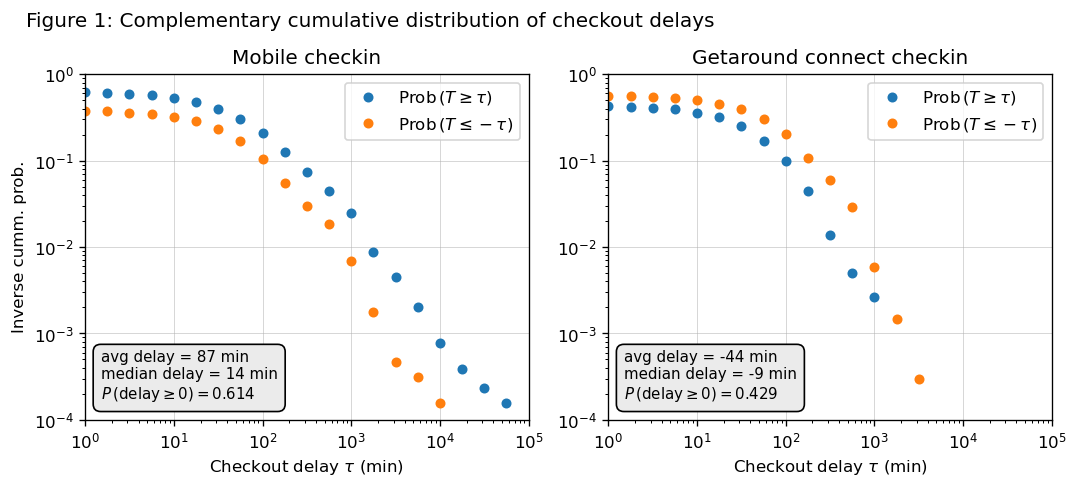

In [10]:
## summary text to display on the figure
summary_text = {k: (f'avg delay = {avg_checkout_delay[k]:.0f} min\n'
                    f'median delay = {median_checkout_delay[k]:.0f} min\n'
                    r'$P\,(\mathrm{delay} \geq 0) '
                    f'= {checkout_distrib[k][0][0]:.3f}$')
                for k in checkout_distrib}

##
fig1, axs1 = plt.subplots(
    nrows=1, ncols=2, figsize=(9, 4), dpi=120,
    gridspec_kw={'left': 0.075, 'right': 0.97, 'top': 0.85, 'bottom': 0.13,
                 'wspace': 0.18})
fig1.suptitle('Figure 1: Complementary cumulative distribution of checkout delays',
              x=0.02, ha='left')

labels = [r'$\mathrm{Prob}\,(T \geq \tau)$', r'$\mathrm{Prob}\, (T \leq - \tau)$']

axs1[0].set_title("Mobile checkin")
line0, = axs1[0].plot(delay_vals, checkout_distrib['mobile'][0],
                      linestyle='', marker='.', markersize=10, color='tab:blue')
line1, = axs1[0].plot(delay_vals, checkout_distrib['mobile'][1],
             linestyle='', marker='.', markersize=10, color='tab:orange')
axs1[0].text(0.035, 0.06, summary_text['mobile'],
             transform=axs1[0].transAxes, fontsize=9,
             bbox={'boxstyle': 'round,pad=0.5', 'facecolor': '0.92'})
axs1[0].grid(visible=True, linewidth=0.3)
axs1[0].set_xscale('log')
axs1[0].set_xlim(1, 1e5)
axs1[0].set_yscale('log')
axs1[0].set_ylim(1e-4, 1)
axs1[0].set_xlabel(r"Checkout delay $\tau$ (min)")
axs1[0].set_ylabel('Inverse cumm. prob.')
axs1[0].legend(handles=[line0, line1], labels=labels)


axs1[1].set_title("Getaround connect checkin")
line0, = axs1[1].plot(delay_vals, checkout_distrib['connect'][0],
                      linestyle='', marker='.', markersize=10, color='tab:blue')
line1, = axs1[1].plot(delay_vals, checkout_distrib['connect'][1],
             linestyle='', marker='.', markersize=10, color='tab:orange')
axs1[1].text(0.035, 0.06, summary_text['connect'],
             transform=axs1[1].transAxes, fontsize=9,
             bbox={'boxstyle': 'round,pad=0.5', 'facecolor': '0.92'})
axs1[1].grid(visible=True, linewidth=0.3)
axs1[1].set_xscale('log')
axs1[1].set_xlim(1, 1e5)
axs1[1].set_yscale('log')
axs1[1].set_ylim(1e-4, 1)
axs1[1].set_xlabel(r"Checkout delay $\tau$ (min)")
axs1[1].legend(handles=[line0, line1], labels=labels)


plt.show()

Figure 1 presents the complementary cummulative distributions of checkout delays, for both mobile checkin (left panel) and Getaround connect checkin (right panel). Most delays are rather short, but delays larger than 12 hours are not infrequent, they occur about 10% of the time. However, there is a significant difference between the two checkin methods. Delays tend to be shorter and occur less frequently with Getaround connect. Moreover, delays larger than a day never occur with Getaround connect.

### Delay with previous rental

We turn to the analysis of the delays between consecutive rentals. We recall that these events are defined rental delays less than 720 min (12 hours), and that they account for only 19% of the cases with Getaround connect and 6% of the cases with mobile checkin.

In [11]:
## Rental delay values
rental_delay = {'mobile': [0, 0], 'connect': [0, 0]}
for (checkin, state), df_ in df.groupby(['checkin_type', 'state']):
    if state == 'ended':
        rental_delay[checkin][0] = df_['time_delta_with_previous_rental_in_minutes'].to_numpy()
    if state == 'canceled':
        rental_delay[checkin][1] = df_['time_delta_with_previous_rental_in_minutes'].to_numpy()

In [12]:
## histogram bins and center values
delay_bins = np.linspace(-30, 750, 14)
delay_vals = (delay_bins[1:] + delay_bins[:-1]) / 2

## 'mobile' delay histograms : ended, canceled, cancelation prob, prob stddev
delay_hist_me, _ = np.histogram(rental_delay['mobile'][0], bins=delay_bins)
delay_hist_mc, _ = np.histogram(rental_delay['mobile'][1], bins=delay_bins)
delay_mfrac = delay_hist_mc / (delay_hist_mc + delay_hist_me)
delay_mfrac_std = delay_mfrac * (1 - delay_mfrac) / np.sqrt(delay_hist_mc + delay_hist_me)

## 'connect' delay histograms : ended, canceled, cancelation prob, prob stddev
delay_hist_ce, _ = np.histogram(rental_delay['connect'][0], bins=delay_bins)
delay_hist_cc, _ = np.histogram(rental_delay['connect'][1], bins=delay_bins)
delay_cfrac = delay_hist_cc / (delay_hist_cc + delay_hist_ce)
delay_cfrac_std = delay_cfrac * (1 - delay_cfrac) / np.sqrt(delay_hist_cc + delay_hist_ce)

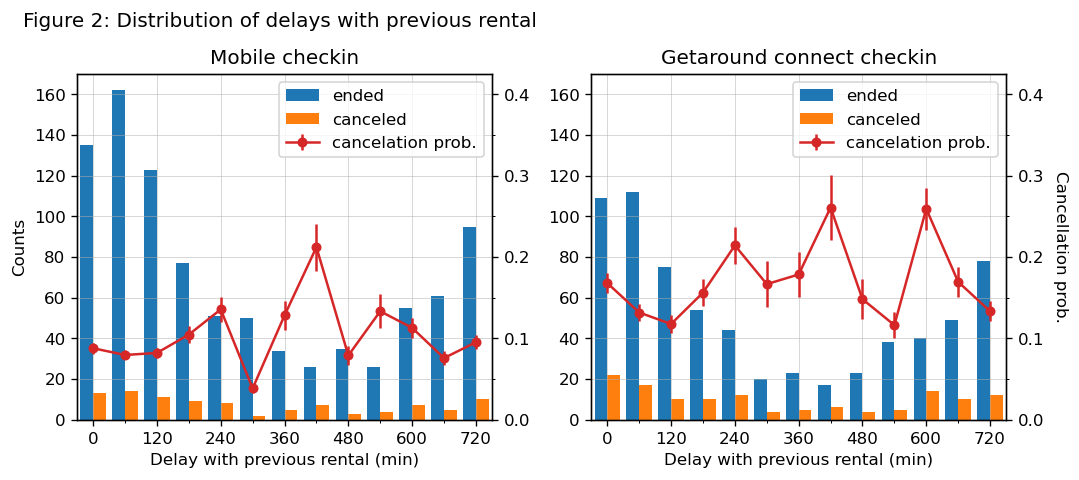

In [13]:
fig2, axs2 = plt.subplots(
    nrows=1, ncols=2, figsize=(9, 4), dpi=120,
    gridspec_kw={'left': 0.07, 'right': 0.93, 'top': 0.85, 'bottom': 0.13,
                 'wspace': 0.24})
axs2_twin = [ax.twinx() for ax in axs2]
fig2.suptitle('Figure 2: Distribution of delays with previous rental', x=0.02, ha='left')


handles = [Patch(facecolor='tab:blue', alpha=1, label='ended'),
           Patch(facecolor='tab:orange', alpha=1, label='canceled')]
labels = ['ended', 'canceled', 'cancelation prob.']

axs2[0].set_title("Mobile checkin")
axs2[0].hist(rental_delay['mobile'], bins=np.linspace(-30, 750, 14),
             stacked=False, density=False)

err = axs2_twin[0].errorbar(delay_vals, delay_mfrac, delay_mfrac_std,
                            color='tab:red', marker='o', markersize=5)
axs2_twin[0].set_ylim(0, 0.425)
axs2_twin[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4])
axs2_twin[0].set_yticks([0.05, 0.15, 0.25, 0.35], minor=True)
# axs2_twin[0].set_ylabel('Cancellation prob.', rotation=270, labelpad=12)

axs2[0].grid(visible=True, linewidth=0.3)
axs2[0].set_xlim(-30, 750)
axs2[0].set_xticks(np.linspace(0, 720, 7))
axs2[0].set_xticks(np.linspace(60, 660, 6), minor=True)
axs2[0].set_xlabel("Delay with previous rental (min)")
axs2[0].set_ylim(0, 170)
axs2[0].set_ylabel("Counts")
axs2[0].legend(handles=handles + [err], labels=labels)


axs2[1].set_title("Getaround connect checkin")
axs2[1].hist(rental_delay['connect'], bins=np.linspace(-30, 750, 14), # np.linspace(-15, 735, 26)
             stacked=False, density=False)

err = axs2_twin[1].errorbar(delay_vals, delay_cfrac, delay_cfrac_std,
                            color='tab:red', marker='o', markersize=5)
axs2_twin[1].set_ylim(0, 0.425)
axs2_twin[1].set_yticks([0, 0.1, 0.2, 0.3, 0.4])
axs2_twin[1].set_yticks([0.05, 0.15, 0.25, 0.35], minor=True)
axs2_twin[1].set_ylabel('Cancellation prob.', rotation=270, labelpad=14)

axs2[1].grid(visible=True, linewidth=0.3)
axs2[1].set_xlim(-30, 750)
axs2[1].set_xticks(np.linspace(0, 720, 7))
axs2[1].set_xticks(np.linspace(60, 660, 6), minor=True)
axs2[1].set_xlabel("Delay with previous rental (min)")
axs2[1].set_ylim(0, 170)
# axs2[1].set_ylabel("Counts")
axs2[1].legend(handles=handles + [err], labels=labels)


plt.show()

We show in figure 2 histograms of the delay with previous rental, for both mobile checkin (left panel) and Getaround connect checkin (right panel), distinguishing ended and caceled rentals. We also show the associated cancellation probability. The histograms are binned with hourly intervals. There is a dip at around 6h rental delay. This is likely a consequence of user car checkout and checkin schedule. Users tend to checkout late in the day and do not checkin at night.

We note that the counts are similar for both checkin methods despite the fact that mobile checkins are 4 times more frequent. We recover the fact that Getaround connect functionality favors consecutive rentals. We also observe the higher probability of cancellation with getaround checkin mentioned above. Interestingly, this cancellation probability seems independent of the rental delay.

## <a id="eda_rentals"></a> Study of consecutive rentals

We now focus on consecutive rentals. In this section we study how the checkout delay of the previous rental affects the subsequent rental. For that purpose, we create a new dataframe by joining the relevant elements that have matching `rental_id` and `previous_ended_rental_id`.

In [14]:
prev_rental_cols = ['rental_id', 'delay_at_checkout_in_minutes']
curr_rental_cols = ['previous_ended_rental_id', 'checkin_type', 'state',
                    'time_delta_with_previous_rental_in_minutes']
df_prev = df.loc[:, prev_rental_cols]
df_curr = df.loc[:, curr_rental_cols]
df2 = pd.merge(df_prev, df_curr, how='inner', left_on='rental_id',
               right_on='previous_ended_rental_id')
df2 = df2.assign(is_canceled=(df2['state'] == 'canceled'))

df2.describe(include='all')

,rental_id,delay_at_checkout_in_minutes,previous_ended_rental_id,checkin_type,state,time_delta_with_previous_rental_in_minutes,is_canceled
count,1841.000000,1729.000000,1841.000000,1841,1841,1841.000000,1841
unique,NaN,NaN,NaN,2,2,NaN,2
top,NaN,NaN,NaN,mobile,ended,NaN,False
freq,NaN,NaN,NaN,1028,1612,NaN,1612
mean,550127.411733,-24.761712,550127.411733,NaN,NaN,279.288430,NaN
std,13184.023111,430.602411,13184.023111,NaN,NaN,254.594486,NaN
min,505628.000000,-4624.000000,505628.000000,NaN,NaN,0.000000,NaN
25%,540896.000000,-54.000000,540896.000000,NaN,NaN,60.000000,NaN
50%,550567.000000,1.000000,550567.000000,NaN,NaN,180.000000,NaN
75%,560823.000000,44.000000,560823.000000,NaN,NaN,540.000000,NaN


### Cancellation probability vs checkout delay

We now study the rental cancellation probability as a function of the delay at checkout of the previous rental. We are still facing the problem of broad checkout delay ranges. For a given time delay $\tau$, we are interested in the cancellation probability when the checkout delay $\tau$ is greater than $t$:
$$
    \mathrm{Prob}\, \left(\mathrm{cancel} \,|\, \tau \geq t \right).
$$

In [15]:
## Bseline cancellation probability for consecutive rentals
df2[['checkin_type', 'is_canceled']].groupby('checkin_type').mean()

,is_canceled
checkin_type,
connect,0.161132
mobile,0.095331


This quantity represents the baseline cancel probability for consecutive rentals or, with the previous expression, $\mathrm{Prob}\left(\mathrm{cancel} | \tau \geq -\infty \right)$. The value is still larger for Getaround connect (16%) than for mobile checkin (9%). However, the difference is reduced as compared to the global cancellation probability including non-consecutive rentals (19% vs 6%, respectively). This means that Getaround connect functionality actually helps mitigating the cancellation issue of consecutive rentals.

In [16]:
## Compute the cumulative cancellation probability vs checkout delay
delay_vals_neg, delay_vals_pos = -np.logspace(4, 0, 21), np.logspace(0, 4, 21)
delay_vals = np.concatenate([delay_vals_neg, delay_vals_pos])
cancel_prob = {}
cancel_prob_std = {}
for (checkin,), df_ in df2.groupby(['checkin_type']):
    prob = np.zeros_like(delay_vals)
    prob_std = np.zeros_like(delay_vals)
    for i, val in enumerate(delay_vals):
        loc = (df_['delay_at_checkout_in_minutes'] >= val)
        p = df_.loc[loc, 'is_canceled'].mean()
        prob[i] = p
        prob_std[i] = p*(1-p) / np.sqrt(df_.loc[loc, 'is_canceled'].sum())

    cancel_prob[checkin] = prob
    cancel_prob_std[checkin] = prob_std


C:\Users\netes\AppData\Local\Temp\ipykernel_9188\1955811335.py:13: RuntimeWarning: invalid value encountered in scalar divide
  prob_std[i] = p*(1-p) / np.sqrt(df_.loc[loc, 'is_canceled'].sum())


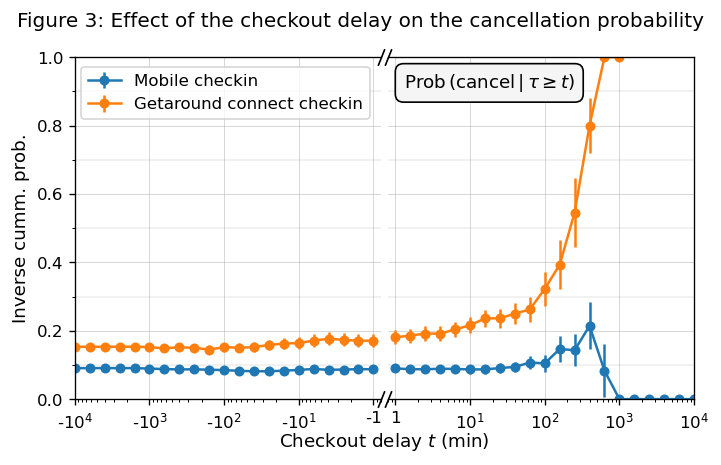

In [17]:
fig3, axs3 = plt.subplots(
    nrows=1, ncols=2, sharey=True, figsize=(6, 3.8), dpi=120,
    gridspec_kw={'left': 0.1, 'right': 0.96, 'top': 0.88, 'bottom': 0.13,
                 'wspace': 0.025})
fig3.suptitle('Figure 3: Effect of the checkout delay on the cancellation probability',
              x=0.02, ha='left')


axs3[0].spines.right.set_visible(False)
axs3[0].plot([1, 1], [0, 1], transform=axs3[0].transAxes,
             marker=[(-0.4, -1), (0.4, 1)], markersize=10, linestyle='',
             color='k', mec='k', mew=1, clip_on=False)
axs3[1].spines.left.set_visible(False)
axs3[1].plot([0, 0], [0, 1], transform=axs3[1].transAxes,
             marker=[(-0.4, -1), (0.4, 1)], markersize=10, linestyle='',
             color='k', mec='k', mew=1, clip_on=False)
axs3[1].tick_params(axis='y', labelleft=False, left=False, which='both')
ms = 5

eb0 = axs3[0].errorbar(delay_vals_pos, cancel_prob['mobile'][20::-1],
                       yerr=cancel_prob_std['mobile'][20::-1],
                       linestyle='-', marker='o', markersize=ms, color='tab:blue')
eb1 = axs3[0].errorbar(delay_vals_pos, cancel_prob['connect'][20::-1],
                       yerr=cancel_prob_std['connect'][20::-1],
                       linestyle='-', marker='o', markersize=ms, color='tab:orange')

axs3[0].grid(visible=True, linewidth=0.3)
axs3[0].grid(visible=True, axis='y', which='minor', linewidth=0.2)
axs3[0].invert_xaxis()
axs3[0].set_xscale('log')
axs3[0].set_xlim(1e4, 0.8)
axs3[0].set_xticks([1e4, 1e3, 1e2, 1e1, 1],
                     ['-$10^4$', '-$10^3$', '-$10^2$', '-$10^1$', '-1'])
axs3[0].set_ylim(0, 1)
axs3[0].set_yticks(np.linspace(0.1, 0.9, 5), minor=True)
axs3[0].set_ylabel('Inverse cumm. prob.', fontsize=11)
axs3[0].legend(handles=[eb0, eb1],
               labels=['Mobile checkin', 'Getaround connect checkin'],
               loc=(0.02, 0.82))


axs3[1].errorbar(delay_vals_pos, cancel_prob['mobile'][21:],
                 yerr=cancel_prob_std['mobile'][21:],
                 linestyle='-', marker='o', markersize=ms, color='tab:blue')
axs3[1].errorbar(delay_vals_pos, cancel_prob['connect'][21:],
                 yerr=cancel_prob_std['connect'][21:],
                 linestyle='-', marker='o', markersize=ms, color='tab:orange')
axs3[1].grid(visible=True, linewidth=0.3)
axs3[1].grid(visible=True, axis='y', which='minor', linewidth=0.2)
axs3[1].set_xscale('log')
axs3[1].set_xlim(0.8, 1e4)
axs3[1].set_xticks([1, 1e1, 1e2, 1e3, 1e4],
                     ['1', '$10^1$', '$10^2$', '$10^3$', '$10^4$'])

axs3[1].text(0.05, 0.91,
             r'$\mathrm{Prob}\, \left(\mathrm{cancel} \,|\, \tau \geq t \right)$',
             transform=axs3[1].transAxes, fontsize=11,
             bbox={'boxstyle': 'round,pad=0.45', 'facecolor': '0.96'})
fig3.text(0.53, 0.025, r"Checkout delay $t$ (min)",
          fontsize=11, ha='center')


plt.show()

Figure 3 presents the cumulative probability of rental cancellation, $\mathrm{Prob}\, \left(\mathrm{cancel} \,|\, T \geq \tau \right)$, for both to the baseline cancellation probability. The curve is roughly constant until $t$ becomes positive. At this point, events with large checkout delay start to contribute, and we observe a rise in cancellation probability for both checkin methods. However, there is a significant difference between the two checkin methods. Although mobile checkin cancellation reaches a maximum of about 20%, the cancellation probability rises sharply with delays larger than 100 min with Getaround connect method.

### Cancellation probability vs customer waiting time

We noted above a sharp increase in the cancellation probability when the checkout delay of the previous rental was in the range 100 - 600 min. We posit that the cancellation of a rental is rather dependent on the customer waiting time $T_{\mathrm{wait}}$, which is defined as the difference $T_{\mathrm{wait}} = \tau - \Delta T$ between the checkout delay $\tau$ and the delay with previous rental $\Delta T$. A positive waiting time $T_{\mathrm{wait}} \geq 0$ means that the next customer actually had to wait for her car.

In [18]:
## Waiting time: difference between checkout delay and rental delay
## Positive when the next customer had to wait
waiting_time = (df2['delay_at_checkout_in_minutes']
                - df2['time_delta_with_previous_rental_in_minutes'])
df2 = df2.assign(waiting_time_in_minutes=waiting_time)

df2['waiting_time_in_minutes'].describe()

count     1729.000000
mean      -301.216310
std        495.582536
min      -4684.000000
25%       -576.000000
50%       -203.000000
75%        -48.000000
max      12548.000000
Name: waiting_time_in_minutes, dtype: float64

Most waiting times are negative, meaning that customers do not have to wait for their car.

In [19]:
## Cumulative cancellation probability vs waiting time
waiting_times = np.linspace(-500, 500, 51)
cancel_prob2 = {}
cancel_prob2_std = {}
for (checkin,), df_ in df2.groupby(['checkin_type']):
    prob = np.zeros_like(waiting_times)
    prob_std =  np.zeros_like(waiting_times)
    for i, val in enumerate(waiting_times):
        loc = (df_['waiting_time_in_minutes'] >= val)
        p = df_.loc[loc, 'is_canceled'].mean()
        prob[i] = p
        prob_std[i] = p*(1-p) / np.sqrt(df_.loc[loc, 'is_canceled'].count())

    cancel_prob2[checkin] = prob
    cancel_prob2_std[checkin] = prob_std

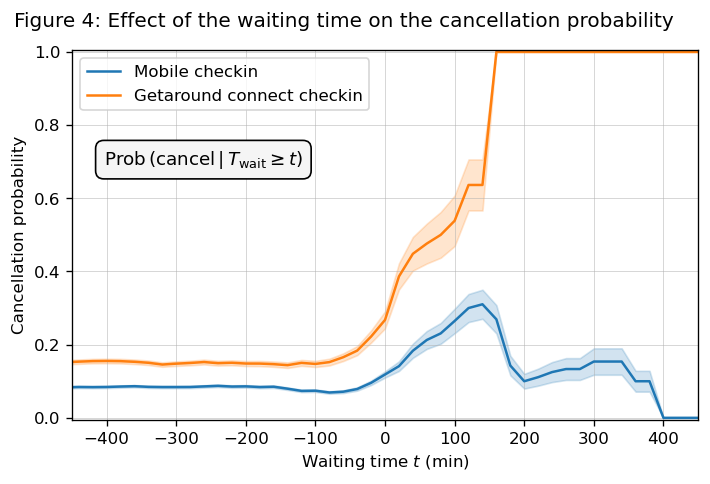

In [20]:
fig4, ax4 = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 4), dpi=120,
    gridspec_kw={'left': 0.1, 'right': 0.97, 'top': 0.9, 'bottom': 0.13,
                 'wspace': 0.24})
fig4.suptitle('Figure 4: Effect of the waiting time on the cancellation probability',
              x=0.02, ha='left')


ax4.plot(waiting_times, cancel_prob2['mobile'],
         color='tab:blue', label='Mobile checkin')
ax4.fill_between(waiting_times, cancel_prob2['mobile']-cancel_prob2_std['mobile'],
                 cancel_prob2['mobile']+cancel_prob2_std['mobile'],
                 color='tab:blue', alpha=0.2)

ax4.plot(waiting_times, cancel_prob2['connect'],
         color='tab:orange', label='Getaround connect checkin')
ax4.fill_between(waiting_times, cancel_prob2['connect']-cancel_prob2_std['connect'],
                 cancel_prob2['connect']+cancel_prob2_std['connect'],
                 color='tab:orange', alpha=0.2)

ax4.grid(visible=True, linewidth=0.3)
ax4.set_xlim(-450, 450)
ax4.set_xticks(np.linspace(-400, 400, 9))
# ax4.set_xticks(np.linspace(60, 660, 6), minor=True)
ax4.set_xlabel("Waiting time $t$ (min)")
ax4.set_ylim(-0.005, 1.005)
ax4.set_ylabel("Cancellation probability")
ax4.legend()

ax4.text(0.21, 0.69,
         r'$\mathrm{Prob}\, \left(\mathrm{cancel} \,|\, T_{\mathrm{wait}} \geq t \right)$',
         ha='center', transform=ax4.transAxes, fontsize=11,
         bbox={'boxstyle': 'round,pad=0.45', 'facecolor': '0.96'})

plt.show()

Figure 4 presents graphs of the rental cancellation probability $\mathrm{Prob}\, \left(\mathrm{cancel} \,|\, T_{\mathrm{wait}} \geq t \right)$ when the waiting time is larger than a time $t$. The light band around the curve represent the uncertainty of the probability estimation. This time, we keep our objective in mind of analyzing the effects of a rental delay. We therefore show the cancellation probability on a linear rather than logarithmic time scale. The relevance of the waiting time is striking: the cancellation probability begins to rise as the waiting time becomes positive. We also stress out the difference in user behavior for the two checkin methods, as previously observed (see figure 3).

## <a id="delay"></a> Introducing a delay between rentals

We conclude by studying the impact of the introduction of a buffer delay $\Delta t$ between rentals. The introduction of such delay was proposed in order to reduce the events in which a user has to wait for her car. The rationale behind this is to improve the image of the company and increase the fidelity of customers. A possible downside of this measure is its impact on the rental revenues.

It would be difficult to completely analyze the impact on revenues with the data at hand (in particular we don't know about Getaround rental pricing policy). We will therefore limit ourselves to the estimation of the number of cancellations avoided by a given rental delay $\Delta t$.

We posit that the waiting time is the sole determinant of rental cancellations, and that user behavior is not affected by the introduction of the rental delay. Under those hypotheses, with a rental delay $\Delta t$, the initial waiting time $t$ of a user becomes $t - \Delta t$. The probability of cancellation is evaluated at this shifted time. On the other hand, the car checkout time has not changed and still corresponds to the original waiting time $t$.
The number of cancellations, n_{\mathrm{cancel}}(\Delta t), can therefore be written:
$$
    n_{\mathrm{cancel}}(\Delta t) = \int_{-\infty}^{\infty} p_{\mathrm{cancel}} (t - \Delta t) \, n_{\mathrm{wait}}(t) \, \mathrm{d}t,
$$
where:
- $p_{\mathrm{cancel}}(t)$ is the probability of cancellation at a waiting time $t$ (*not* when the waiting time is *larger* than $t$).
- $n_{\mathrm{wait}}(t)$ is the density of cars returned with waiting time $t$. In the following we take this quantity normalized to unity, so that the number of cars is obtained by multiplying with the total number of cars available.


### Determination of the relevant quantities

As we have seen, we now need to estimate *densities* instead of cumulative quantities. We do so by estimating the quantities of interest in binned regions (eg computing histograms). However, one of the drawbacks of this method is that we get a poor estimation in regions with low data.

In [21]:
## Probability density estimation bins and center values
time_bins = np.linspace(-750, 750, 26)
time_vals = (time_bins[1:] + time_bins[:-1]) / 2

## Probabilities
p_cancel = {} # cancellation probability
std_p_cancel = {} # std dev estimate of cancellation probability
pd_waiting_time = {} # waiting time probability density
for (checkin,), df_ in df2.groupby(['checkin_type']):
    # the two extremal points correspond to values outside the bins
    prob = np.zeros(len(time_vals)+2, dtype=float)
    std_prob = np.zeros(len(time_vals)+2, dtype=float)
    counts = np.zeros(len(time_vals)+2, dtype=int)

    df_ = df_.loc[~df_['waiting_time_in_minutes'].isna()]
    idx = np.digitize(df_['waiting_time_in_minutes'], time_bins)
    for i in range(len(time_bins) + 1):
        temp = df_.iloc[idx == i]['is_canceled']
        counts[i] = temp.count()
        prob[i] = temp.mean()
        std_prob[i] = prob[i]*(1-prob[i]) / np.sqrt(counts[i])

    p_cancel[checkin] = prob
    std_p_cancel[checkin] = std_prob
    pd_waiting_time[checkin] = counts / np.sum(counts)

In [22]:
## Baseline cancellation probabilities (waiting time <= 0)
df_ = df2.loc[df2['waiting_time_in_minutes'] <= 0]
df_.loc[:, ['checkin_type', 'is_canceled']].groupby('checkin_type').mean()

,is_canceled
checkin_type,
connect,0.141274
mobile,0.084918


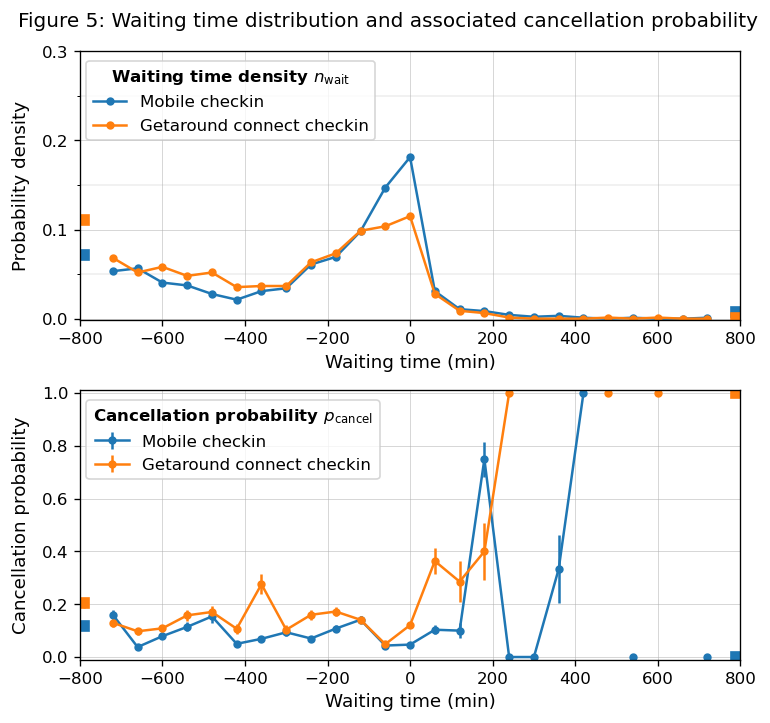

In [23]:
fig5, axs5 = plt.subplots(
    nrows=2, ncols=1, figsize=(6.4, 6), dpi=120,
    gridspec_kw={'left': 0.1, 'right': 0.96, 'top': 0.925, 'bottom': 0.08,
                 'hspace': 0.26})
fig5.suptitle('Figure 5: Waiting time distribution and associated cancellation probability',
              x=0.02, ha='left')


x = 790 # position out of range probabilities


axs5[0].plot(time_vals, pd_waiting_time['mobile'][1:-1],
             color='tab:blue', marker='o', markersize=4,
             label='Mobile checkin')
axs5[0].plot([-x, x], pd_waiting_time['mobile'][[0, -1]],
             color='tab:blue', linestyle='', marker='s', markersize=6)

axs5[0].plot(time_vals, pd_waiting_time['connect'][1:-1],
             color='tab:orange', marker='o', markersize=4,
             label='Getaround connect checkin')
axs5[0].plot([-x, x], pd_waiting_time['connect'][[0, -1]],
             color='tab:orange', linestyle='', marker='s', markersize=6)

axs5[0].grid(visible=True, linewidth=0.3)
axs5[0].grid(visible=True, which='minor', linewidth=0.2)
axs5[0].set_xlim(-800, 800)
axs5[0].set_xlabel('Waiting time (min)', fontsize=11)
axs5[0].set_ylim(-0.002, 0.3)
axs5[0].set_yticks(np.linspace(0, 0.3, 4))
axs5[0].set_yticks(np.linspace(0.05, 0.25, 3), minor=True)
axs5[0].set_ylabel("Probability density", fontsize=11, labelpad=7)
axs5[0].legend(loc=(0.01, 0.67),
               title=r'Waiting time density $n_{\mathrm{wait}}$',
               title_fontproperties={'weight': 'bold'})


axs5[1].errorbar(time_vals, p_cancel['mobile'][1:-1], std_p_cancel['mobile'][1:-1],
                       color='tab:blue', marker='o', markersize=4,
                       label='Mobile checkin')
axs5[1].errorbar([-x, x], p_cancel['mobile'][[0, -1]], std_p_cancel['mobile'][[0, -1]],
             color='tab:blue', linestyle='', marker='s', markersize=6)

axs5[1].errorbar(time_vals, p_cancel['connect'][1:-1], std_p_cancel['connect'][1:-1],
                       color='tab:orange', marker='o', markersize=4,
                       label='Getaround connect checkin')
axs5[1].errorbar([-x, x], p_cancel['connect'][[0, -1]], std_p_cancel['connect'][[0, -1]],
             color='tab:orange', linestyle='', marker='s', markersize=6)

axs5[1].grid(visible=True, linewidth=0.3)
axs5[1].set_xlim(-800, 800)
axs5[1].set_xlabel('Waiting time (min)', fontsize=11)
axs5[1].set_ylim(-0.01, 1.01)
axs5[1].set_ylabel("Cancellation probability", fontsize=11, labelpad=7)
axs5[1].legend(loc=(0.01, 0.67), 
               title=r'Cancellation probability $p_{\mathrm{cancel}}$',
               title_fontproperties={'weight': 'bold'})

plt.show()

We show in figure 5 the probability density of waiting times (top panel) the cancellation probability in binned waiting time ranges (bottom panel) for both checkin methods. The bins are 60 min wide, ranging from -750 minutes to 750 minutes. The square symbols at the plot edges represent the estimation in the intervals outside the bin ranges, $]-\infty, 750]$ and $]750, \infty[$. For instance, in the bottom panel, 7% of the waiting times are less than -750 min (that is, the car was returned more than 12h before the next checkin).

- The baseline cancellation rate can be estimated by averaging the values for negative waiting times.
We get 8% and 14% for mobile checkin and getaround connect, respectively.
- The waiting times distribution reaches a peak at zero then decrease sharply. This indicates that users try as much as possible to return the car on time for the next checkin when they are late. It therefore seems that users also take into account the next checkin time when returning their car. A user may feel more comfortable being late if the next checkin is scheduled much later than their expected checkout time. This observed behavior may impair our estimation of the number of canellations avoided. Indeed, users could tolerate to return their car with a higher checkout delay in response to the introduction of the rental delay feature.
- Positive waiting times are actually not so frequent. Such low amount of data available makes the cancellation probability estimation difficult in this domain.

### Effect of the rental delay on the number of cancellations

We finally evaluate the impact of the proposed rental delay on the number of cancellations. The code below adapts the analysis of the previous section to handle the low amount of data available in some ranges of waiting time.

For the sake of completeness, we repeat here the whole data treatment process the is relevant to the application.

In [24]:
## Prepare the dataset
# load
raw_df = pd.read_excel('./data/get_around_delay_analysis.xlsx')
# join pairs of subsequent rentals
prev_rental_cols = ['rental_id', 'delay_at_checkout_in_minutes']
curr_rental_cols = ['previous_ended_rental_id', 'checkin_type', 'state',
                    'time_delta_with_previous_rental_in_minutes']
df = pd.merge(raw_df.loc[:, prev_rental_cols], raw_df.loc[:, curr_rental_cols],
              how='inner', left_on='rental_id',
              right_on='previous_ended_rental_id')
df = df.assign(is_canceled=(df['state'] == 'canceled'))
# compute waiting time
waiting_time = (df['delay_at_checkout_in_minutes']
                - df['time_delta_with_previous_rental_in_minutes'])
df = df.assign(waiting_time=waiting_time)

In [25]:
def rental_delay_info(dataset: pd.DataFrame,
                      time_delta: float,
                      p_cancel: dict[str, np.ndarray],
                      p_cancel_bins: np.ndarray)-> dict[str, float]:
    """
    Estimate the impact of the introduction of a rental delay `time_delta` on
    the number of rental cancellations, for both checkin methods.
    
    The computation requires an estimate of the cancellation probability in
    contiguous time intervals. `time_delta` is expressed in minutes.
    
    The function returns a dict[str, float] with entries
    - '<checkin>_n_rentals': the total number of rentals using the given <checkin>
      method that are potentially affected by the rental delay.
    - '<checkin>_cancel_frac': the estimated fraction of rental cancellations
      for the given <checkin> method. This estimate includes the baseline
      cancellation rate. It should be multiplied by the estimated cancel
      fraction to get an estimate of the actual number of cancellations.
    """
    info = {}
    for (checkin,), df in dataset.groupby(['checkin_type']):
        ntot = len(df) # total cars affected, include those with missing values
        df = df.loc[~df['waiting_time'].isna()]
        
        idx = np.digitize(df['waiting_time'], p_cancel_bins + time_delta)
        cancel_frac = np.sum(p_cancel[checkin][idx]) / len(df)
        
        info[checkin+'_n_rentals'] = ntot
        info[checkin+'_cancel_frac'] = cancel_frac

    return info

In [26]:
## Cancellation probability estimation
p_cancel_bins = np.linspace(-15, 225, 5)
p_cancel = {}
p0_cancel = {} # baseline cancellation proba

for (checkin,), df_ in df.groupby(['checkin_type']):
    df_ = df_.loc[~df_['waiting_time'].isna()]

    p0_cancel[checkin] = df_['is_canceled'].mean()

    prob = np.zeros(len(p_cancel_bins)+1, dtype=float)
    idx = np.digitize(df_['waiting_time'], p_cancel_bins)
    for i in range(len(p_cancel_bins)+1):
        prob[i] = df_.iloc[idx == i]['is_canceled'].mean()
    p_cancel[checkin] = prob

In [27]:
time_delta = 120 # minutes
rental_delay_info(df, time_delta, p_cancel, p_cancel_bins)

{'connect_n_rentals': 813,
 'connect_cancel_frac': np.float64(0.1462415883346894),
 'mobile_n_rentals': 1028,
 'mobile_cancel_frac': np.float64(0.09112714257184602)}

In [28]:
## Cars cancellation vs rental delay
rental_delays = np.linspace(-120, 300, 22)
connect_cancel_frac = np.zeros_like(rental_delays)
mobile_cancel_frac = np.zeros_like(rental_delays)
for i, dt in enumerate(rental_delays):
    info = rental_delay_info(df, dt, p_cancel, p_cancel_bins)
    connect_cancel_frac[i] = info['connect_cancel_frac']
    mobile_cancel_frac[i] = info['mobile_cancel_frac']
connect_n_cars = info['connect_n_rentals']
mobile_n_cars = info['mobile_n_rentals']

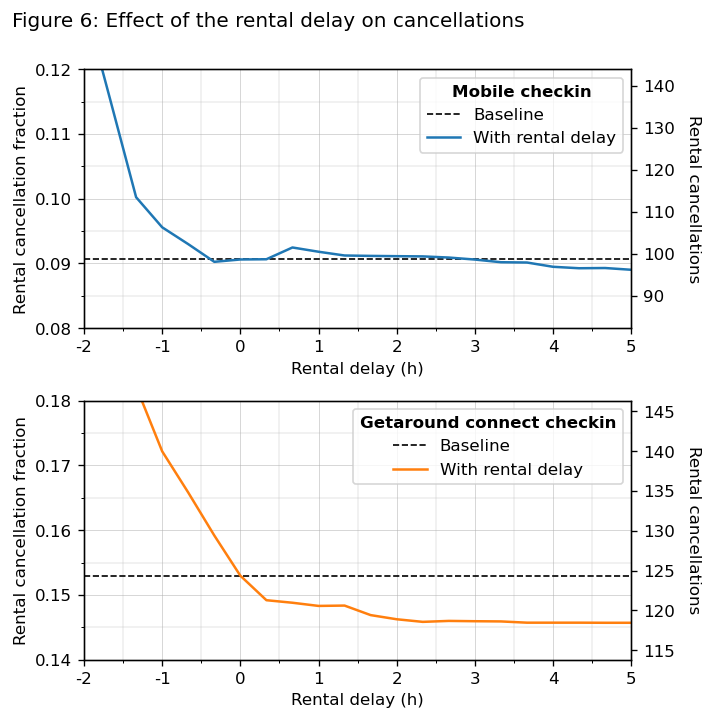

In [29]:
fig6, axs6 = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6), dpi=120,
    gridspec_kw={'left': 0.12, 'right': 0.88, 'top': 0.9, 'bottom': 0.08,
                 'hspace': 0.28})
axs6_twin = [ax.twinx() for ax in axs6]
fig6.suptitle('Figure 6: Effect of the rental delay on cancellations', x=0.02, ha='left')

labels = ['Baseline', 'With rental delay']


l0 = axs6[0].axhline(p0_cancel['mobile'], color='k', linestyle='--', linewidth=1)
l1, = axs6[0].plot(rental_delays, mobile_cancel_frac)

axs6_twin[0].set_ylim(0.08*mobile_n_cars, 0.14*mobile_n_cars)
axs6_twin[0].set_ylabel('Rental cancellations', rotation=270, labelpad=16)

axs6[0].grid(visible=True, linewidth=0.3)
axs6[0].grid(visible=True, linewidth=0.2, which='minor')
axs6[0].set_xlim(-120, 300)
axs6[0].set_xticks(np.linspace(-120, 300, 8), np.arange(-2, 6))
axs6[0].set_xticks(np.linspace(-90, 270, 7), minor=True)
axs6[0].set_xlabel("Rental delay (h)")
axs6[0].set_ylim(0.08, 0.12)
axs6[0].set_yticks(np.linspace(0.085, 0.115, 4), minor=True)
axs6[0].set_ylabel("Rental cancellation fraction")
axs6[0].legend(handles=[l0, l1], labels=labels,
               title='Mobile checkin',
               title_fontproperties={'weight': 'bold'})


l0 = axs6[1].axhline(p0_cancel['connect'], color='k', linestyle='--', linewidth=1)
l1, = axs6[1].plot(rental_delays, connect_cancel_frac, color='tab:orange')

axs6_twin[1].set_ylim(0.14*connect_n_cars, 0.18*connect_n_cars)
axs6_twin[1].set_ylabel('Rental cancellations', rotation=270, labelpad=16)

axs6[1].grid(visible=True, linewidth=0.3)
axs6[1].grid(visible=True, linewidth=0.2, which='minor')
axs6[1].set_xlim(-120, 300)
axs6[1].set_xticks(np.linspace(-120, 300, 8), np.arange(-2, 6))
axs6[1].set_xticks(np.linspace(-90, 270, 7), minor=True)
axs6[1].set_xlabel("Rental delay (h)")
axs6[1].set_ylim(0.14, 0.18)
axs6[1].set_yticks(np.linspace(0.145, 0.175, 4), minor=True)
axs6[1].set_ylabel("Rental cancellation fraction")
axs6[1].legend(handles=[l0, l1], labels=labels,
               title='Getaround connect checkin',
               title_fontproperties={'weight': 'bold'})


plt.show()

Figure 6 presents the rental cancellation fraction as a function of the delay introduced between two consecutive rentals for both mobile checkin (top panel) and Getaround connect checkin (bottom panel). The dashed black line represents the baseline cancellation rate.
- The cancellation rate increases sharply in the negative rental delay region. This corresponds to making the car available before the expected checkout time. Our analysis is thus in accordance with the very intuitive fact that doing so would create high friction between users and cause an important increase of rental cancellations.
- The introduction of such delay does not impact rentals using mobile checkin, with a cancellation rate that remains constant at around 9%.
- The introduction of the rental delay decreases significantly the number of cancellations. A delay of about 2h leads to an absolute decrease of about 0.7% (4.5% relative). This corresponds to 5 to 6 cancellations in the pool of 813 rentals of the dataset.

## <a id="conclusion"></a> Conclusion and perspectives

We studied the user behavior relative to the delay with expected car checkout time and its potential impact on the next user.
- Checkout delays have a broad distribution. Most are less than 2 hours from the expected value, but there is a significant number of large outliers. Very large values are probably due to events such as accidents or car breakdowns.
- The Getaround connect functionality tends to reduce the occurence of such large delays.
- The downside is that users using the Getaround connect functionality are less tolerant to checkout delays. We showed that this is related to the actual user waiting time.
- The problem is less frequent when users do not use the Getaround functionality. This is likely because two consecutive users keep contact with their smartphone and can synchronize for any delay.

To circumvent the problem of rental cancellation, it is proposed to introduce a delay between the expected checkout time and the car availability for a subsequent rental.
- We designed a simple model to estimate the number of cancellations avoided, by computing the convolution between the waiting time density and the cancellation probability.
- We determined that rentals using mobile checkin would not benefit from this feature.
- For Getaround connect checkin, we established that a rental delay of about 2h would be beneficial to rental cancellations, with an expected absolute reduction of about 0.7%.


Our analysis showed that users tend to take into account the next checkin time when returning their car. They tend to return their car later (ie causing a larger checkout delay) if they have a good margin. The proposed introduction of a rental delay may therefore not be as efficient as predicted. Other approaches are possible to circumvent this problem. For instance the application could show to the current driver a checkin time closer to the checkout than what it actually is.